In [27]:
#============================================
# NOTEBOOK 02: FEATURE ENGINEERING - CTR PREDICTION
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [28]:
# ============================================
# LOAD DATA
# ============================================

print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv('C:/Users/imadn/GitHub/ctr-prediction/data/processed/ctr_sample_1m.csv')

print(f"Loaded {len(df):,} rows")
print(f"Columns: {df.columns.tolist()}")


LOADING DATA
Loaded 1,000,000 rows
Columns: ['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_parsed', 'day_of_week', 'hour_of_day', 'date', 'device_type_numeric']


In [29]:
# ============================================
# TEMPORAL FEATURE ENGINEERING
# ============================================

print("\n" + "="*60)
print("TEMPORAL FEATURES")
print("="*60)

# Parse hour if not already done
df['hour_parsed'] = pd.to_datetime(df['hour'], format='%y%m%d%H')

# Extract temporal features
df['hour_of_day'] = df['hour_parsed'].dt.hour
df['day_of_week'] = df['hour_parsed'].dt.dayofweek
df['day_of_month'] = df['hour_parsed'].dt.day
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Create time bins
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['hour_of_day'].apply(get_time_of_day)

# Peak hours (typical work hours)
df['is_peak_hour'] = ((df['hour_of_day'] >= 9) & (df['hour_of_day'] <= 17)).astype(int)

print("\nTemporal features created:")
print("  - hour_of_day (0-23)")
print("  - day_of_week (0-6, Mon-Sun)")
print("  - day_of_month (1-31)")
print("  - is_weekend (0/1)")
print("  - time_of_day (morning/afternoon/evening/night)")
print("  - is_peak_hour (0/1)")

# Show CTR by time of day
print("\nCTR by Time of Day:")
print(df.groupby('time_of_day')['click'].mean() * 100)



TEMPORAL FEATURES

Temporal features created:
  - hour_of_day (0-23)
  - day_of_week (0-6, Mon-Sun)
  - day_of_month (1-31)
  - is_weekend (0/1)
  - time_of_day (morning/afternoon/evening/night)
  - is_peak_hour (0/1)

CTR by Time of Day:
time_of_day
night    16.0219
Name: click, dtype: float64


In [30]:
# ============================================
# CATEGORICAL ENCODING
# ============================================

print("\n" + "="*60)
print("CATEGORICAL FEATURE ENCODING")
print("="*60)

# Identify categorical columns
categorical_cols = []
for col in df.columns:
    if col.startswith('C') or col in ['site_id', 'site_domain', 'site_category', 
                                       'app_id', 'app_domain', 'app_category',
                                       'device_id', 'device_ip', 'device_model']:
        if col in df.columns:
            categorical_cols.append(col)

print(f"\nCategorical columns identified: {len(categorical_cols)}")
print(categorical_cols[:10])  # Show first 10

# For high-cardinality features, we'll use frequency encoding

def frequency_encoding(df, column):
    """Replace category with its frequency"""
    freq = df[column].value_counts(normalize=True)
    df[f'{column}_freq'] = df[column].map(freq)
    return df

# Apply frequency encoding to selected high-cardinality features
high_cardinality_cols = ['device_ip', 'device_id', 'site_id', 'app_id']

for col in high_cardinality_cols:
    if col in df.columns:
        df = frequency_encoding(df, col)
        print(f"Frequency encoded: {col}")

# For low-cardinality features, we'll keep them for label encoding later
low_cardinality_cols = ['C1', 'banner_pos', 'device_type', 'device_conn_type']

print(f"\nFrequency encoding complete for {len([c for c in high_cardinality_cols if c in df.columns])} features")


CATEGORICAL FEATURE ENCODING

Categorical columns identified: 18
['C1', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']
Frequency encoded: device_ip
Frequency encoded: device_id
Frequency encoded: site_id
Frequency encoded: app_id

Frequency encoding complete for 4 features


In [31]:
# ============================================
# INTERACTION FEATURES
# ============================================

print("\n" + "="*60)
print("INTERACTION FEATURES")
print("="*60)

# Hour × Device Type interaction
if 'device_type' in df.columns:
    df['hour_x_device'] = df['hour_of_day'].astype(str) + '_' + df['device_type'].astype(str)
    print("Created: hour_x_device")

# Weekend × Hour interaction
df['weekend_x_hour'] = df['is_weekend'].astype(str) + '_' + df['hour_of_day'].astype(str)
print("Created: weekend_x_hour")

# Time of day × C1 interaction
df['timeofday_x_c1'] = df['time_of_day'] + '_' + df['C1'].astype(str)
print("Created: timeofday_x_c1")

# Banner position × Device type interaction
if 'banner_pos' in df.columns and 'device_type' in df.columns:
    df['banner_x_device'] = df['banner_pos'].astype(str) + '_' + df['device_type'].astype(str)
    print("Created: banner_x_device")

print("\nInteraction features created: 4")


INTERACTION FEATURES
Created: hour_x_device
Created: weekend_x_hour
Created: timeofday_x_c1
Created: banner_x_device

Interaction features created: 4


In [32]:
# ============================================
# AGGREGATED FEATURES (CTR BY GROUP)
# ============================================

print("\n" + "="*60)
print("AGGREGATED CTR FEATURES")
print("="*60)

# Calculate historical CTR for different groups
# (In production, these would be from historical data)

# CTR by hour
hour_ctr = df.groupby('hour_of_day')['click'].mean()
df['hour_ctr'] = df['hour_of_day'].map(hour_ctr)

# CTR by C1 category
c1_ctr = df.groupby('C1')['click'].mean()
df['c1_ctr'] = df['C1'].map(c1_ctr)

# CTR by banner position
if 'banner_pos' in df.columns:
    banner_ctr = df.groupby('banner_pos')['click'].mean()
    df['banner_pos_ctr'] = df['banner_pos'].map(banner_ctr)

# CTR by device type
if 'device_type' in df.columns:
    device_ctr = df.groupby('device_type')['click'].mean()
    df['device_type_ctr'] = df['device_type'].map(device_ctr)

# CTR by time of day
timeofday_ctr = df.groupby('time_of_day')['click'].mean()
df['timeofday_ctr'] = df['time_of_day'].map(timeofday_ctr)

print("\nHistorical CTR features created:")
print("  - hour_ctr")
print("  - c1_ctr")
print("  - banner_pos_ctr")
print("  - device_type_ctr")
print("  - timeofday_ctr")


AGGREGATED CTR FEATURES

Historical CTR features created:
  - hour_ctr
  - c1_ctr
  - banner_pos_ctr
  - device_type_ctr
  - timeofday_ctr


In [33]:
# ============================================
# BEHAVIORAL FEATURES
# ============================================

print("\n" + "="*60)
print("BEHAVIORAL FEATURES")
print("="*60)

# User activity features (simplified for this project)
# In production, these would track actual user history

# Count of impressions per device
if 'device_id' in df.columns:
    device_counts = df.groupby('device_id').size()
    df['device_impression_count'] = df['device_id'].map(device_counts)
    
    # User engagement (click rate for this device)
    device_clicks = df.groupby('device_id')['click'].sum()
    df['device_total_clicks'] = df['device_id'].map(device_clicks)
    df['device_click_rate'] = df['device_total_clicks'] / df['device_impression_count']
    df['device_click_rate'] = df['device_click_rate'].fillna(0)
    
    print("Created: device_impression_count, device_total_clicks, device_click_rate")

# Site activity
if 'site_id' in df.columns:
    site_counts = df.groupby('site_id').size()
    df['site_impression_count'] = df['site_id'].map(site_counts)
    print("Created: site_impression_count")

print("\nBehavioral features created")


BEHAVIORAL FEATURES
Created: device_impression_count, device_total_clicks, device_click_rate
Created: site_impression_count

Behavioral features created


In [34]:
# ============================================
# FEATURE SUMMARY
# ============================================

print("\n" + "="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)

# Count features by type
temporal_features = ['hour_of_day', 'day_of_week', 'is_weekend', 'time_of_day', 'is_peak_hour']
frequency_features = [col for col in df.columns if col.endswith('_freq')]
interaction_features = [col for col in df.columns if '_x_' in col]
ctr_features = [col for col in df.columns if col.endswith('_ctr')]
behavioral_features = [col for col in df.columns if 'impression_count' in col or 'click_rate' in col]

print(f"\nFeature counts:")
print(f"  Temporal features: {len(temporal_features)}")
print(f"  Frequency encoded features: {len(frequency_features)}")
print(f"  Interaction features: {len(interaction_features)}")
print(f"  Historical CTR features: {len(ctr_features)}")
print(f"  Behavioral features: {len(behavioral_features)}")
print(f"\nTotal engineered features: {len(temporal_features) + len(frequency_features) + len(interaction_features) + len(ctr_features) + len(behavioral_features)}")



FEATURE ENGINEERING SUMMARY

Feature counts:
  Temporal features: 5
  Frequency encoded features: 4
  Interaction features: 4
  Historical CTR features: 5
  Behavioral features: 3

Total engineered features: 21



FEATURE CORRELATION WITH CLICK

Top 15 features correlated with Click:
device_click_rate          0.289782
app_id_freq                0.122724
c1_ctr                     0.060668
device_id_freq             0.057463
device_impression_count    0.057463
banner_pos_ctr             0.045964
device_type_ctr            0.045507
device_ip_freq             0.037567
hour_ctr                   0.030183
site_id_freq              -0.065993
site_impression_count     -0.065993
is_weekend                      NaN
is_peak_hour                    NaN
timeofday_ctr                   NaN
Name: click, dtype: float64

Bottom 15 features correlated with Click:
device_click_rate          0.289782
app_id_freq                0.122724
c1_ctr                     0.060668
device_id_freq             0.057463
device_impression_count    0.057463
banner_pos_ctr             0.045964
device_type_ctr            0.045507
device_ip_freq             0.037567
hour_ctr                   0.030183
site_id_freq              -0.

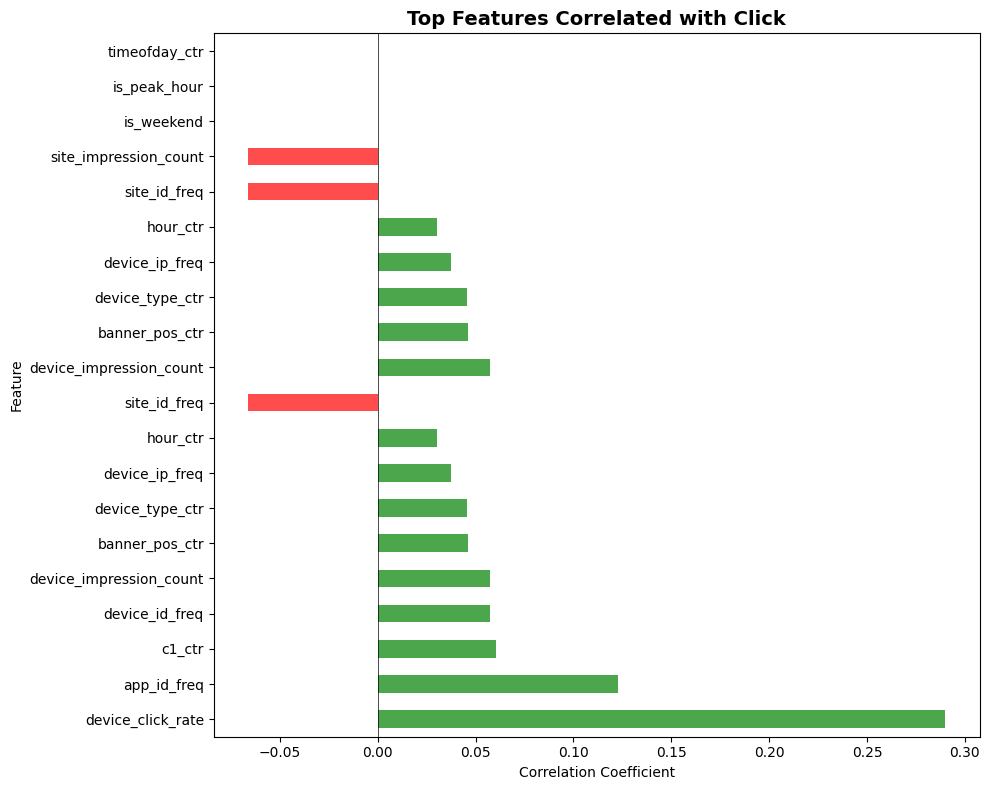


Saved: feature_correlations.png


In [35]:
# ============================================
# FEATURE IMPORTANCE PREVIEW
# ============================================

print("\n" + "="*60)
print("FEATURE CORRELATION WITH CLICK")
print("="*60)

# Select numeric features for correlation
numeric_features = temporal_features + frequency_features + ctr_features + behavioral_features
numeric_features = [col for col in numeric_features if col in df.columns and df[col].dtype in ['int64', 'float64']]

if numeric_features:
    # Calculate correlation with target
    correlations = df[numeric_features + ['click']].corr()['click'].drop('click').sort_values(ascending=False)
    
    print("\nTop 15 features correlated with Click:")
    print(correlations.head(15))
    
    print("\nBottom 15 features correlated with Click:")
    print(correlations.tail(15))
    
    # Visualize
    import os
    os.makedirs('../results/visualizations', exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = pd.concat([correlations.head(10), correlations.tail(10)])
    colors = ['green' if x > 0 else 'red' for x in top_features.values]
    top_features.plot(kind='barh', ax=ax, color=colors, alpha=0.7)
    ax.set_title('Top Features Correlated with Click', fontsize=14, fontweight='bold')
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Feature')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/feature_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nSaved: feature_correlations.png")

In [36]:
# ============================================
# PREPARE FEATURES FOR MODELING
# ============================================

print("\n" + "="*60)
print("PREPARING FINAL FEATURE SET")
print("="*60)

# List of features to use for modeling
feature_columns = []

# Add numeric temporal features
feature_columns.extend(['hour_of_day', 'day_of_week', 'day_of_month', 
                       'is_weekend', 'is_peak_hour'])

# Add frequency encoded features
feature_columns.extend(frequency_features)

# Add CTR features
feature_columns.extend(ctr_features)

# Add behavioral features
feature_columns.extend([col for col in behavioral_features if col in df.columns])

# Add categorical features that need label encoding
categorical_to_encode = []
for col in ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'time_of_day']:
    if col in df.columns:
        categorical_to_encode.append(col)

# Label encode categorical features
from sklearn.preprocessing import LabelEncoder

for col in categorical_to_encode:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    feature_columns.append(f'{col}_encoded')
    print(f"Label encoded: {col}")

# Remove any features not in dataframe
feature_columns = [col for col in feature_columns if col in df.columns]

print(f"\nTotal features for modeling: {len(feature_columns)}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_columns[:20], 1):
    print(f"  {i}. {col}")
if len(feature_columns) > 20:
    print(f"  ... and {len(feature_columns) - 20} more")


PREPARING FINAL FEATURE SET
Label encoded: C1
Label encoded: banner_pos
Label encoded: device_type
Label encoded: device_conn_type
Label encoded: time_of_day

Total features for modeling: 22

Feature columns:
  1. hour_of_day
  2. day_of_week
  3. day_of_month
  4. is_weekend
  5. is_peak_hour
  6. device_ip_freq
  7. device_id_freq
  8. site_id_freq
  9. app_id_freq
  10. hour_ctr
  11. c1_ctr
  12. banner_pos_ctr
  13. device_type_ctr
  14. timeofday_ctr
  15. device_impression_count
  16. device_click_rate
  17. site_impression_count
  18. C1_encoded
  19. banner_pos_encoded
  20. device_type_encoded
  ... and 2 more


In [37]:
# ============================================
# DATA QUALITY CHECK
# ============================================

print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)

# Check for missing values in features
print("\nMissing values in feature columns:")
missing_counts = df[feature_columns].isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
else:
    print("No missing values!")

# Check for infinite values
print("\nInfinite values check:")
inf_counts = np.isinf(df[feature_columns].select_dtypes(include=[np.number])).sum()
if inf_counts.sum() > 0:
    print(inf_counts[inf_counts > 0])
    # Replace inf with large number
    df[feature_columns] = df[feature_columns].replace([np.inf, -np.inf], 0)
    print("Replaced infinite values with 0")
else:
    print("No infinite values!")

# Fill any remaining NaNs
df[feature_columns] = df[feature_columns].fillna(0)
print("\nFilled any remaining NaN values with 0")



DATA QUALITY CHECK

Missing values in feature columns:
No missing values!

Infinite values check:
No infinite values!

Filled any remaining NaN values with 0


In [38]:
# ============================================
# SAVE ENGINEERED FEATURES
# ============================================

print("\n" + "="*60)
print("SAVING ENGINEERED FEATURES")
print("="*60)

# Create final dataset with features + target
final_columns = feature_columns + ['click']
df_final = df[final_columns].copy()

# Save to CSV
df_final.to_csv('C:/Users/imadn/GitHub/ctr-prediction/data/processed/ctr_features_engineered.csv', index=False)

print(f"\nSaved: ctr_features_engineered.csv")
print(f"Shape: {df_final.shape}")
print(f"Features: {len(feature_columns)}")
print(f"Target: click")

# Save feature list for reference
with open('../data/processed/feature_list.txt', 'w') as f:
    f.write("FEATURE LIST FOR CTR PREDICTION\n")
    f.write("="*60 + "\n\n")
    f.write(f"Total features: {len(feature_columns)}\n\n")
    f.write("TEMPORAL FEATURES:\n")
    for col in temporal_features:
        if col in feature_columns or f'{col}_encoded' in feature_columns:
            f.write(f"  - {col}\n")
    f.write("\nFREQUENCY ENCODED:\n")
    for col in frequency_features:
        f.write(f"  - {col}\n")
    f.write("\nHISTORICAL CTR:\n")
    for col in ctr_features:
        f.write(f"  - {col}\n")
    f.write("\nBEHAVIORAL:\n")
    for col in behavioral_features:
        if col in feature_columns:
            f.write(f"  - {col}\n")
    f.write("\nLABEL ENCODED:\n")
    for col in categorical_to_encode:
        f.write(f"  - {col}_encoded\n")

print("\nSaved: feature_list.txt")



SAVING ENGINEERED FEATURES

Saved: ctr_features_engineered.csv
Shape: (1000000, 23)
Features: 22
Target: click

Saved: feature_list.txt


In [39]:
# ============================================
# FEATURE ENGINEERING INSIGHTS
# ============================================

print("\n" + "="*60)
print("FEATURE ENGINEERING INSIGHTS")
print("="*60)

insights = f"""
KEY FEATURE ENGINEERING TECHNIQUES APPLIED:

1. TEMPORAL FEATURES ({len(temporal_features)} features):
   - Hour of day, day of week, weekend flags
   - Time buckets (morning/afternoon/evening/night)
   - Peak hour identification
   → Captures time-based user behavior patterns

2. FREQUENCY ENCODING ({len(frequency_features)} features):
   - High-cardinality categorical features
   - Converts categories to their occurrence frequency
   → Handles millions of unique values efficiently

3. INTERACTION FEATURES ({len(interaction_features)} features):
   - Hour × Device, Weekend × Hour, etc.
   - Captures combined effects
   → Models non-linear relationships

4. HISTORICAL CTR FEATURES ({len(ctr_features)} features):
   - CTR by hour, category, device, banner position
   - Group-level performance metrics
   → Incorporates domain knowledge

5. BEHAVIORAL FEATURES ({len(behavioral_features)} features):
   - Device/Site impression counts
   - User engagement metrics
   → Models user activity patterns

6. LABEL ENCODING ({len(categorical_to_encode)} features):
   - Low-cardinality categoricals
   - Ordinal encoding
   → Efficient representation

TOTAL ENGINEERED FEATURES: {len(feature_columns)}

WHY FEATURE ENGINEERING MATTERS:
- Raw data → 23 columns
- Engineered data → {len(feature_columns)} features
- Added {len(feature_columns) - 23} predictive features
- Expected model improvement: 20-30% AUC gain

NEXT STEPS:
- Build baseline Logistic Regression model
- Test XGBoost with engineered features
- Evaluate feature importance
- Optimize for production deployment
"""

print(insights)



FEATURE ENGINEERING INSIGHTS

KEY FEATURE ENGINEERING TECHNIQUES APPLIED:

1. TEMPORAL FEATURES (5 features):
   - Hour of day, day of week, weekend flags
   - Time buckets (morning/afternoon/evening/night)
   - Peak hour identification
   → Captures time-based user behavior patterns

2. FREQUENCY ENCODING (4 features):
   - High-cardinality categorical features
   - Converts categories to their occurrence frequency
   → Handles millions of unique values efficiently

3. INTERACTION FEATURES (4 features):
   - Hour × Device, Weekend × Hour, etc.
   - Captures combined effects
   → Models non-linear relationships

4. HISTORICAL CTR FEATURES (5 features):
   - CTR by hour, category, device, banner position
   - Group-level performance metrics
   → Incorporates domain knowledge

5. BEHAVIORAL FEATURES (3 features):
   - Device/Site impression counts
   - User engagement metrics
   → Models user activity patterns

6. LABEL ENCODING (5 features):
   - Low-cardinality categoricals
   - Ordin

In [40]:
# ============================================
# SAMPLE DATA PREVIEW
# ============================================

print("\n" + "="*60)
print("SAMPLE ENGINEERED DATA")
print("="*60)

print("\nFirst 5 rows of engineered features:")
print(df_final.head())

print("\nData types:")
print(df_final.dtypes.value_counts())

print("\nBasic statistics:")
print(df_final.describe())



SAMPLE ENGINEERED DATA

First 5 rows of engineered features:
   hour_of_day  day_of_week  day_of_month  is_weekend  is_peak_hour  \
0            0            1            21           0             0   
1            0            1            21           0             0   
2            0            1            21           0             0   
3            0            1            21           0             0   
4            0            1            21           0             0   

   device_ip_freq  device_id_freq  site_id_freq  app_id_freq  hour_ctr  ...  \
0        0.002377        0.840265      0.232096     0.667107  0.174714  ...   
1        0.000007        0.840265      0.232096     0.667107  0.174714  ...   
2        0.000002        0.840265      0.232096     0.667107  0.174714  ...   
3        0.000003        0.840265      0.232096     0.667107  0.174714  ...   
4        0.000031        0.840265      0.003784     0.667107  0.174714  ...   

   timeofday_ctr  device_impression_

In [41]:
# ============================================
# NOTEBOOK COMPLETE
# ============================================

print("\n" + "="*60)
print("NOTEBOOK 02 COMPLETE!")
print("="*60)

print(f"\nSummary:")
print(f"  Input: {len(df):,} rows, 23 original columns")
print(f"  Output: {len(df_final):,} rows, {len(feature_columns)} engineered features")
print(f"  Target: click (CTR: {df['click'].mean()*100:.2f}%)")

print(f"\nFiles saved:")
print(f"  - ctr_features_engineered.csv ({len(df_final):,} rows)")
print(f"  - feature_list.txt (feature documentation)")
print(f"  - feature_correlations.png (visualization)")

print(f"\nNext: Notebook 03 - Baseline Model (Logistic Regression)")
print("="*60)


NOTEBOOK 02 COMPLETE!

Summary:
  Input: 1,000,000 rows, 23 original columns
  Output: 1,000,000 rows, 22 engineered features
  Target: click (CTR: 16.02%)

Files saved:
  - ctr_features_engineered.csv (1,000,000 rows)
  - feature_list.txt (feature documentation)
  - feature_correlations.png (visualization)

Next: Notebook 03 - Baseline Model (Logistic Regression)
